In [1]:
# SLA Predictor application
# CLASS Project: https://class-project.eu/

#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#
#
# Created on 25 Mar 2021
# @author: Jorge Montero - ATOS
#

# prometheus_api_client

In [14]:
from prometheus_api_client import PrometheusConnect
prom = PrometheusConnect(url ="http://192.168.7.42:9091/", disable_ssl=True)

# Get the list of all the metrics that the Prometheus host scrapes
prom.all_metrics()

['deadlines_missed_0fn5jwwiuvnoj6smtfwk7u1614155040086017752',
 'deadlines_missed_0j6apqscnzd2pfst2hktfc1615372473841624998',
 'deadlines_missed_0rrkko98mqwnmxsceme2x41614601459187461562',
 'deadlines_missed_15dvgrrvvdsm9xmxcta7md1614004570092499581',
 'deadlines_missed_1qikxbsn3dnjsetcr8wyqf1614004893766124876',
 'deadlines_missed_1qnf41hn9kmhi32fwup0zg1612543146431620328',
 'deadlines_missed_1zrbnoporm44hg1rusa2iv1614006681162815415',
 'deadlines_missed_1zs6xnmelt1oe9jsfw5edx1614589304010498708',
 'deadlines_missed_252yyxfxtp6fkjxnthjgxl1614071503322899071',
 'deadlines_missed_37kuwnhjgfz8uhjun7d2b11614588612274250339',
 'deadlines_missed_3vpkbo6hov6euumavbqhfa1614585635341454788',
 'deadlines_missed_3xbztukcovhfleoe0qfhbj1614158096406654380',
 'deadlines_missed_6bjfx2kguvjr337m58v55f1614248755678305737',
 'deadlines_missed_6dw1pwexfossssofs7tyhk1615297278605891440',
 'deadlines_missed_77039ip9uv8b2bntls4iky1615298033775262248',
 'deadlines_missed_7mfwrw1us1amlmptaxbvhf16141535726286

# EDA (Exploratory Data Analysis)

Load the prometheus metrics and filter them by type

In [1]:
raw_metrics_files = ["metrics1.txt","metrics2.txt","metrics3.txt","metrics4.txt","metrics5.txt"]

In [2]:
import pandas as pd

raw_metrics_names = []
raw_metrics_types = []
raw_metrics_descriptions = []

description = ""
metric_name = ""
metric_type = ""

raw_metrics = []
for raw_metrics_file in raw_metrics_files:
    with open(raw_metrics_file) as f:
        raw_metrics = raw_metrics + f.read().splitlines()
            
for raw_metric in raw_metrics:
    if raw_metric.startswith('# HELP'):
        description = " ".join(raw_metric.split(" ")[3:])
        #print(description)
    if raw_metric.startswith('# TYPE'):
        metric_name = raw_metric.split(" ")[2]
        metric_type = raw_metric.split(" ")[3]
        #print(metric_name)
        #print(metric_type)
        
        if metric_name not in raw_metrics_names:
            raw_metrics_names.append(metric_name) 
            raw_metrics_types.append(metric_type) 
            raw_metrics_descriptions.append(description)
        
raw_metrics_json = {}
raw_metrics_json["name"] = raw_metrics_names 
raw_metrics_json["type"] = raw_metrics_types 
raw_metrics_json["description"] = raw_metrics_descriptions

raw_metrics_df = pd.DataFrame(raw_metrics_json)
raw_metrics_df

,name,type,description
0,go_gc_duration_seconds,summary,A summary of the pause duration of garbage col...
1,go_goroutines,gauge,Number of goroutines that currently exist.
2,go_info,gauge,Information about the Go environment.
3,go_memstats_alloc_bytes,gauge,Number of bytes allocated and still in use.
4,go_memstats_alloc_bytes_total,counter,"Total number of bytes allocated, even if freed."
...,...,...,...
254,process_virtual_memory_bytes,gauge,Virtual memory size in bytes.
255,process_virtual_memory_max_bytes,gauge,Maximum amount of virtual memory available in ...
256,promhttp_metric_handler_errors_total,counter,Total number of internal errors encountered by...
257,promhttp_metric_handler_requests_in_flight,gauge,Current number of scrapes being served.


In [3]:
raw_metrics_df[raw_metrics_df["type"]=="gauge"]

,name,type,description
1,go_goroutines,gauge,Number of goroutines that currently exist.
2,go_info,gauge,Information about the Go environment.
3,go_memstats_alloc_bytes,gauge,Number of bytes allocated and still in use.
5,go_memstats_buck_hash_sys_bytes,gauge,Number of bytes used by the profiling bucket h...
7,go_memstats_gc_cpu_fraction,gauge,The fraction of this program's available CPU t...
...,...,...,...
252,process_resident_memory_bytes,gauge,Resident memory size in bytes.
253,process_start_time_seconds,gauge,Start time of the process since unix epoch in ...
254,process_virtual_memory_bytes,gauge,Virtual memory size in bytes.
255,process_virtual_memory_max_bytes,gauge,Maximum amount of virtual memory available in ...


In [4]:
raw_metrics_df[raw_metrics_df["type"]=="summary"]

,name,type,description
0,go_gc_duration_seconds,summary,A summary of the pause duration of garbage col...


In [5]:
raw_metrics_df[raw_metrics_df["type"]=="histogram"]

,name,type,description


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Funtion to aggregate all the instances data of the timeseries for each metric

In [7]:
def get_timeseries_from_metric(metric_name,start_time,end_time,chunk_size):
    metric_data = prom.get_metric_range_data(
        metric_name,  # this is the metric name and label config
        start_time=start_time,
        end_time=end_time,
        chunk_size=chunk_size,
    )
    
    # do some process to it: merging all timeseries values to one, and get the aggregated value
    metric_d_all_df = pd.DataFrame()
    if metric_data:
        for i in range(0,len(metric_data)):
            metric_d_df = pd.DataFrame(metric_data[i]["values"],columns=["timestamp", metric_name+str(i)])
            metric_d_df['timestamp']= pd.to_datetime(metric_d_df['timestamp'], unit='s')
            metric_d_df[metric_name+str(i)]= pd.to_numeric(metric_d_df[metric_name+str(i)], errors='coerce')
            metric_d_df.set_index('timestamp', inplace=True)

            metric_d_all_df = pd.concat([metric_d_all_df, metric_d_df], axis=0)

        #metric_d_all_df = metric_d_all_df.groupby(pd.Grouper(freq='1Min')).aggregate("last")

        metric_d_agg_df = metric_d_all_df
        metric_d_agg_df[metric_name] = metric_d_all_df.aggregate("mean", axis=1)
        #return metric_d_agg_df[metric_name]     

        metric_data_insert = []
        metric_data_insert_time = metric_d_agg_df.index.values
        metric_data_insert_val = metric_d_agg_df[metric_name].values
        for i in range(0,len(metric_data_insert_time)):
            metric_data_insert.append([metric_data_insert_time[i],metric_data_insert_val[i]])
        metric_data_df = pd.DataFrame(metric_data_insert,columns=["timestamp", metric_name])
        metric_data_df['timestamp']= pd.to_datetime(metric_data_df['timestamp'], unit='s')
        metric_data_df[metric_name]= pd.to_numeric(metric_data_df[metric_name], errors='coerce')
        metric_data_df.set_index('timestamp', inplace=True)
        return metric_data_df
    
    else:
        return pd.DataFrame()

Display the histogram and the normal distribution

In [38]:
import seaborn as sns
from scipy import stats
from scipy.stats import norm

def draw_hist_norm(data,metric_name):
    # Dibujamos el historgrama de frecuencias.
    plt.figure(figsize=(15,8))
    sns.set(color_codes = True)
    ax = sns.distplot(data, bins=100, kde=False, fit=stats.norm, color='green')

    # Obtenemos Los parómetros ajustados de la distribución normal utilizados por SNS
    (mu, sigma) = stats.norm.fit(data)

    # Configuramos el título del gráfico, legendas y etiquetas.
    plt.title('Historical distribution of '+metric_name,fontsize = 16)
    plt.ylabel('Freq')
    plt.legend(["Normal distribution. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma),
    "Distribution of "+metric_name])
    plt.show()

Describe skewness and kurtosis

In [40]:
def get_skew(data):
    skew = float(data.skew())
    print("Skewness: %f" % skew)
    if skew <= 0.5 and skew >= -0.5:
        print("  fairly symmetrical")
    elif (skew <= 1 and skew > 0.5) or (skew < -0.5 and skew >= -1):
        print("  moderately skewed")
    elif skew > 1 or skew < -1 :
        print("  highly skewed")

#If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
#If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed
#If the skewness is less than -1 or greater than 1, the data are highly skewed

def get_kurt(data):
    kurt = float(data.kurt())
    print("Kurtosis: %f" % kurt)
    if kurt > 0:
        print("  leptokurtic distribution. Values in a leptokurtic distribution are near the mean or at the extremes.")
    elif kurt == 0:
        print("  platykurtic distribution. Looks more close to a normal distribution.")
    elif kurt < 0:
        print("  mesokurtic distribution. Values are moderately spread out.")
    
#If the distribution is tall and thin it is called a leptokurtic distribution(Kurtosis > 3). Values in a leptokurtic distribution are near the mean or at the extremes.
#A flat distribution where the values are moderately spread out (i.e., unlike leptokurtic) is called platykurtic(Kurtosis <3) distribution.
#A distribution whose shape is in between a leptokurtic distribution and a platykurtic distribution is called a mesokurtic(Kurtosis=3) distribution. A mesokurtic distribution looks more close to a normal distribution.

Describe the stationarity of the timeseries

In [41]:
from statsmodels.tsa.stattools import adfuller

def get_adfuller(data):
    adf = adfuller(data, maxlag=1)
    print("T-test: "+str(adf[0]))
    print("P-value: "+str(adf[1]))
    print("Critical values: "+str(adf[4]))
    
    if adf[0] < adf[4]["5%"]:
        print("  Null hypothesis discarded -> stationarity with 5%")
    else:
        print("  Null hypothesis not discarded -> stationarity is not provided at 5% -> it contains time relation")

Describe hurst to analyse the timeseries trend

In [55]:
from hurst import compute_Hc

def get_hurst(data):
    
    # compute_Hc returns a tuple of 3 values 
    H, c, val = compute_Hc(data, simplified=True)
    
    print("Hurst exponent = {:.4f}".format(H))
    if H > 0.5:
        print("  persistent process (trend)")
    elif H == 0.5:
        print("  brownian motion (random walk)")
    elif H < 0.5:
        print("  anti-persistent process (mean revert)")

    return H

# 0 < H < 1
# H > 0,5 persistent process (trend)
# H = 0,5 brownian motion (random walk)
# H < 0,5 anti-persistent process (mean revert)

Retrieve the last hour for each metric and generate the EDA for each one

go_goroutines
2021-03-10 15:24:51.214596
2021-03-10 16:24:51.217604
                               go_goroutines
timestamp                                   
2021-03-10 14:25:02.020999936            7.0
2021-03-10 14:25:32.020999936            8.0
2021-03-10 14:26:02.020999936            7.0
2021-03-10 14:26:32.020999936            7.0
2021-03-10 14:27:02.020999936            7.0
...                                      ...
2021-03-10 15:23:39.080000000           11.0
2021-03-10 15:23:54.080000000           11.0
2021-03-10 15:24:09.080000000           11.0
2021-03-10 15:24:24.080000000           11.0
2021-03-10 15:24:39.080000000           11.0

[840 rows x 1 columns]


       go_goroutines
count     840.000000
mean        8.310714
std         1.747433
min         7.000000
25%         7.000000
50%         7.000000
75%        11.000000
max        12.000000


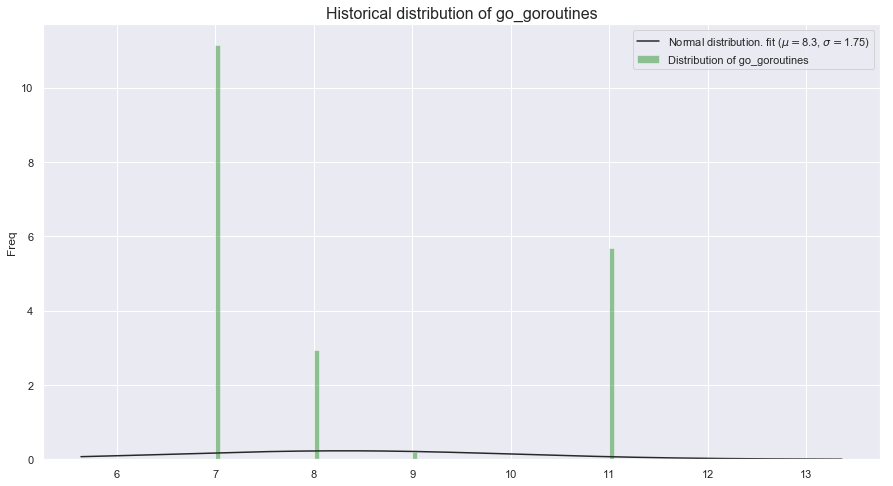



Skewness: 0.815868
  moderately skewed
Kurtosis: -1.199200
  mesokurtic distribution. Values are moderately spread out.


T-test: -4.176787643384755
P-value: 0.0007211174169716788
Critical values: {'1%': -3.4381774989729816, '5%': -2.8649951426291, '10%': -2.568609799556849}
  Null hypothesis discarded -> stationarity with 5%


Hurst exponent = 0.3065
  anti-persistent process (mean revert)

--------------------------------------------------

go_info
2021-03-10 15:24:51.214596
2021-03-10 16:24:51.217604
                               go_info
timestamp                             
2021-03-10 14:25:02.020999936      1.0
2021-03-10 14:25:32.020999936      1.0
2021-03-10 14:26:02.020999936      1.0
2021-03-10 14:26:32.020999936      1.0
2021-03-10 14:27:02.020999936      1.0
...                                ...
2021-03-10 15:23:39.080000000      1.0
2021-03-10 15:23:54.080000000      1.0
2021-03-10 15:24:09.080000000      1.0
2021-03-10 15:24:24.080000000      1.0
2021-03-10 15:24:39.0

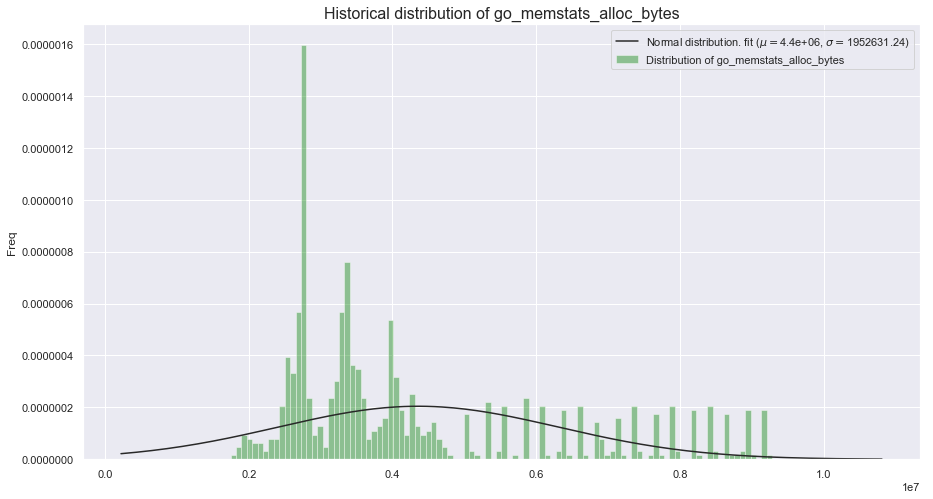



Skewness: 1.055132
  highly skewed
Kurtosis: -0.101013
  mesokurtic distribution. Values are moderately spread out.


T-test: -7.046238324334879
P-value: 5.677255131792454e-10
Critical values: {'1%': -3.4381774989729816, '5%': -2.8649951426291, '10%': -2.568609799556849}
  Null hypothesis discarded -> stationarity with 5%


Hurst exponent = 0.2360
  anti-persistent process (mean revert)

--------------------------------------------------

go_memstats_buck_hash_sys_bytes
2021-03-10 15:24:51.214596
2021-03-10 16:24:51.217604
                               go_memstats_buck_hash_sys_bytes
timestamp                                                     
2021-03-10 14:25:02.020999936                        1990847.0
2021-03-10 14:25:32.020999936                        1990847.0
2021-03-10 14:26:02.020999936                        1990847.0
2021-03-10 14:26:32.020999936                        1990847.0
2021-03-10 14:27:02.020999936                        1990847.0
...                         

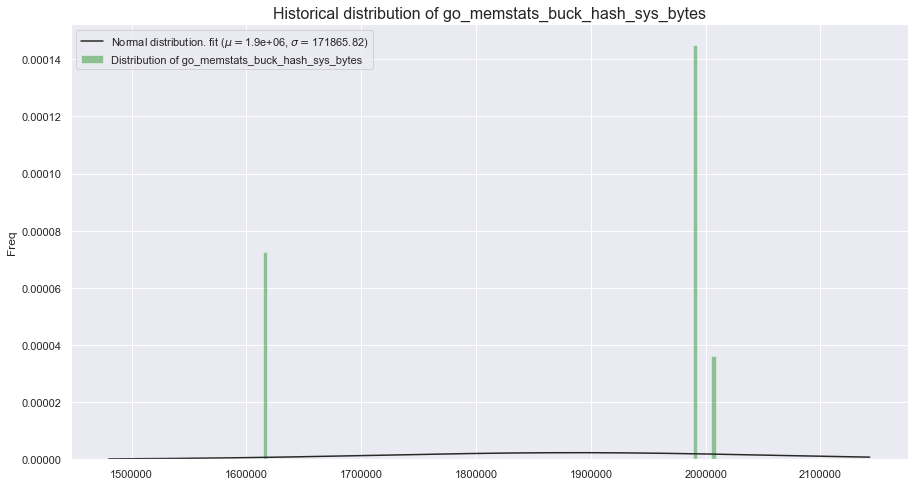



Skewness: -0.946303
  moderately skewed
Kurtosis: -1.100904
  mesokurtic distribution. Values are moderately spread out.


T-test: -3.6141565518710626
P-value: 0.005496081492847356
Critical values: {'1%': -3.438168140637663, '5%': -2.864991017121922, '10%': -2.5686076019468094}
  Null hypothesis discarded -> stationarity with 5%


Hurst exponent = 0.2323
  anti-persistent process (mean revert)

--------------------------------------------------

go_memstats_gc_cpu_fraction
2021-03-10 15:24:51.214596
2021-03-10 16:24:51.217604
                               go_memstats_gc_cpu_fraction
timestamp                                                 
2021-03-10 14:25:02.020999936                     0.000015
2021-03-10 14:25:32.020999936                     0.000015
2021-03-10 14:26:02.020999936                     0.000015
2021-03-10 14:26:32.020999936                     0.000015
2021-03-10 14:27:02.020999936                     0.000015
...                                                  

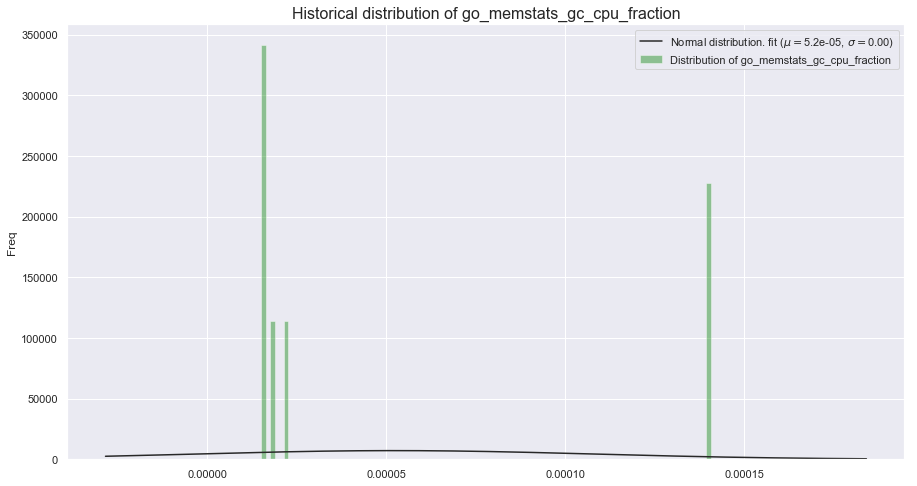



Skewness: 0.945640
  moderately skewed
Kurtosis: -1.101564
  mesokurtic distribution. Values are moderately spread out.


T-test: -3.5692501401171253
P-value: 0.006376853979787962
Critical values: {'1%': -3.438168140637663, '5%': -2.864991017121922, '10%': -2.5686076019468094}
  Null hypothesis discarded -> stationarity with 5%


Hurst exponent = 0.1516
  anti-persistent process (mean revert)

--------------------------------------------------

go_memstats_gc_sys_bytes
2021-03-10 15:24:51.214596
2021-03-10 16:24:51.217604
                               go_memstats_gc_sys_bytes
timestamp                                              
2021-03-10 14:25:02.020999936                 3582216.0
2021-03-10 14:25:32.020999936                 3582216.0
2021-03-10 14:26:02.020999936                 3582216.0
2021-03-10 14:26:32.020999936                 3582216.0
2021-03-10 14:27:02.020999936                 3582216.0
...                                                 ...
2021-03-10 15:23:39.08

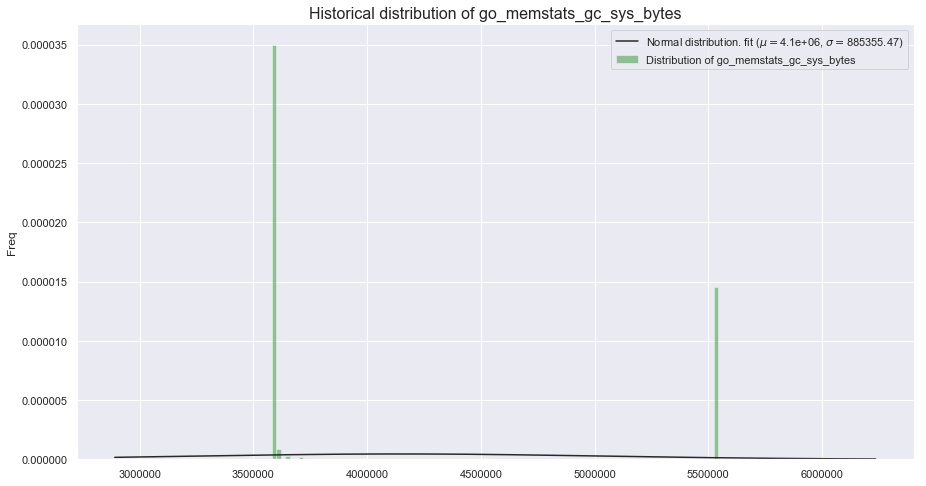



Skewness: 0.949674
  moderately skewed
Kurtosis: -1.099791
  mesokurtic distribution. Values are moderately spread out.


T-test: -3.571459014150334
P-value: 0.006330706420719262
Critical values: {'1%': -3.438168140637663, '5%': -2.864991017121922, '10%': -2.5686076019468094}
  Null hypothesis discarded -> stationarity with 5%


Hurst exponent = 0.2929
  anti-persistent process (mean revert)

--------------------------------------------------



In [57]:
# Import the required datetime functions
from prometheus_api_client.utils import parse_datetime
from datetime import timedelta

start_time = parse_datetime("1h")
end_time = parse_datetime("now")
chunk_size = timedelta(minutes=10)

metrics_all_df = pd.DataFrame()

for metric_name in raw_metrics_df[raw_metrics_df["type"]=="gauge"]["name"][:6]:
    print(metric_name)
    print(start_time)
    print(end_time)
    metric_data_df = get_timeseries_from_metric(metric_name,start_time,end_time,chunk_size)
    print(metric_data_df)
    print("\n")
    if not metric_data_df.empty:
        
        metrics_all_df = pd.concat([metrics_all_df, metric_data_df], axis=0)
        
        print(metric_data_df.describe())
        #sns.distplot(metric_data_df["values"]);
        if len(list(set(metric_data_df[metric_name]))) > 1:
            draw_hist_norm(metric_data_df,metric_name)
            print("\n")
            get_skew(metric_data_df)
            get_kurt(metric_data_df)
            print("\n")
            get_adfuller(metric_data_df)
            print("\n")
            if metric_data_df[metric_name].count() > 100:
                get_hurst(metric_data_df[metric_name].values)
    print("\n--------------------------------------------------\n")

Aggregate all the metrics into one, and per minute

In [ ]:
metrics_all_df

In [137]:
metrics_all_df = metrics_all_df.groupby(pd.Grouper(freq='1Min')).aggregate("last")
metrics_all_df

,go_goroutines,go_info,go_memstats_alloc_bytes,go_memstats_buck_hash_sys_bytes,go_memstats_gc_cpu_fraction,go_memstats_gc_sys_bytes,go_memstats_heap_alloc_bytes,go_memstats_heap_idle_bytes,go_memstats_heap_inuse_bytes,go_memstats_heap_objects,...,node_timex_tick_seconds,node_udp_queues,node_uname_info,process_max_fds,process_open_fds,process_resident_memory_bytes,process_start_time_seconds,process_virtual_memory_bytes,process_virtual_memory_max_bytes,promhttp_metric_handler_requests_in_flight
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-02-24 10:37:00,7.0,1.0,3111536.0,1972455.0,0.000015,3582216.0,3111536.0,61448192.0,4808704.0,11377.0,...,0.01,0.0,1.0,1048576.0,9.0,25243648.0,1.612092e+09,735117312.0,-1.0,1.0
2021-02-24 10:38:00,8.0,1.0,2802216.0,1972455.0,0.000015,3582216.0,2802216.0,61808640.0,4481024.0,8204.0,...,0.01,0.0,1.0,1048576.0,9.0,25243648.0,1.612092e+09,735117312.0,-1.0,1.0
2021-02-24 10:39:00,7.0,1.0,2695232.0,1972455.0,0.000015,3582216.0,2695232.0,62038016.0,4251648.0,8028.0,...,0.01,0.0,1.0,1048576.0,9.0,25243648.0,1.612092e+09,735117312.0,-1.0,1.0
2021-02-24 10:40:00,7.0,1.0,3421672.0,1972455.0,0.000015,3582216.0,3421672.0,61095936.0,5226496.0,14090.0,...,0.01,0.0,1.0,1048576.0,9.0,25243648.0,1.612092e+09,735117312.0,-1.0,1.0
2021-02-24 10:41:00,7.0,1.0,2966592.0,1972455.0,0.000015,3582216.0,2966592.0,61669376.0,4620288.0,9647.0,...,0.01,0.0,1.0,1048576.0,9.0,25243648.0,1.612092e+09,735117312.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-24 11:33:00,7.0,1.0,2700280.0,1972455.0,0.000015,3582216.0,2700280.0,62013440.0,4308992.0,8104.0,...,0.01,0.0,1.0,1048576.0,9.0,25243648.0,1.612092e+09,735117312.0,-1.0,1.0
2021-02-24 11:34:00,7.0,1.0,3393376.0,1972455.0,0.000015,3582216.0,3393376.0,61161472.0,5160960.0,13363.0,...,0.01,0.0,1.0,1048576.0,9.0,25243648.0,1.612092e+09,735117312.0,-1.0,1.0
2021-02-24 11:35:00,8.0,1.0,2871848.0,1972455.0,0.000015,3582216.0,2871848.0,61743104.0,4579328.0,9199.0,...,0.01,0.0,1.0,1048576.0,9.0,25243648.0,1.612092e+09,735117312.0,-1.0,1.0


Display the correlation matrix

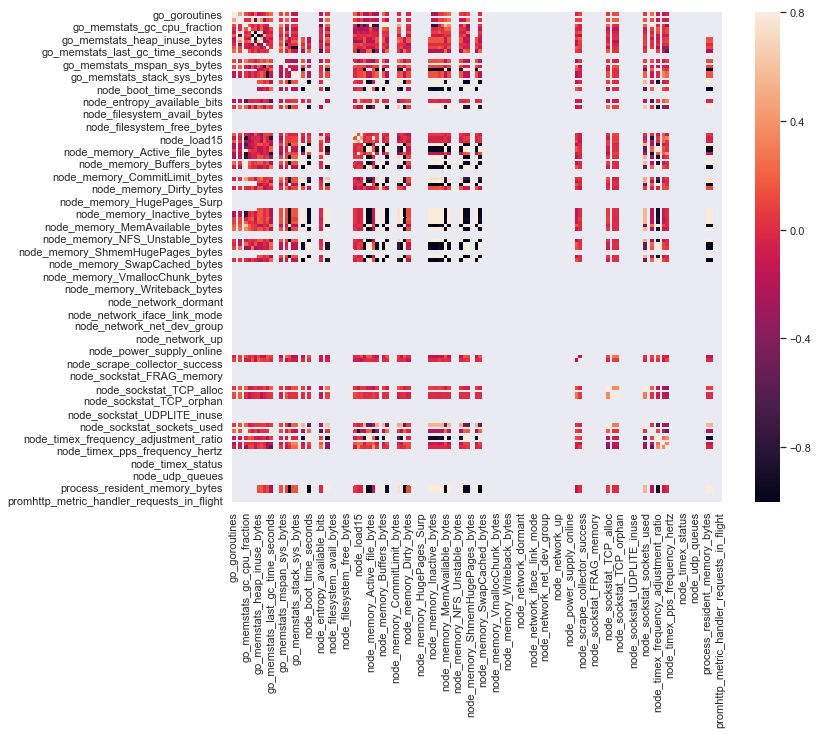

In [138]:
# Correlation matrix

corrmat = metrics_all_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [139]:
# check columns with all NaN values to remove them
nan_columns = corrmat.isnull().values.all(axis=0)
nan_columns_names = corrmat[nan_columns].index.values
#print(nan_columns_names)

non_nan_columns = [not elem for elem in nan_columns]
non_nan_columns_names = corrmat[non_nan_columns].index.values
print(non_nan_columns_names)

['go_goroutines' 'go_memstats_alloc_bytes' 'go_memstats_gc_cpu_fraction'
 'go_memstats_gc_sys_bytes' 'go_memstats_heap_alloc_bytes'
 'go_memstats_heap_idle_bytes' 'go_memstats_heap_inuse_bytes'
 'go_memstats_heap_objects' 'go_memstats_heap_released_bytes'
 'go_memstats_heap_sys_bytes' 'go_memstats_last_gc_time_seconds'
 'go_memstats_mspan_inuse_bytes' 'go_memstats_next_gc_bytes'
 'go_memstats_other_sys_bytes' 'go_memstats_stack_inuse_bytes'
 'go_memstats_stack_sys_bytes' 'go_threads' 'node_boot_time_seconds'
 'node_entropy_available_bits' 'node_filefd_allocated' 'node_load1'
 'node_load15' 'node_load5' 'node_memory_Active_anon_bytes'
 'node_memory_Active_bytes' 'node_memory_Active_file_bytes'
 'node_memory_AnonHugePages_bytes' 'node_memory_AnonPages_bytes'
 'node_memory_Buffers_bytes' 'node_memory_Cached_bytes'
 'node_memory_Committed_AS_bytes' 'node_memory_DirectMap2M_bytes'
 'node_memory_DirectMap4k_bytes' 'node_memory_Dirty_bytes'
 'node_memory_Inactive_anon_bytes' 'node_memory_Inac

In [140]:
metrics_all_df[non_nan_columns_names]

,go_goroutines,go_memstats_alloc_bytes,go_memstats_gc_cpu_fraction,go_memstats_gc_sys_bytes,go_memstats_heap_alloc_bytes,go_memstats_heap_idle_bytes,go_memstats_heap_inuse_bytes,go_memstats_heap_objects,go_memstats_heap_released_bytes,go_memstats_heap_sys_bytes,...,node_sockstat_TCP_alloc,node_sockstat_TCP_mem,node_sockstat_TCP_mem_bytes,node_sockstat_sockets_used,node_time_seconds,node_timex_frequency_adjustment_ratio,node_timex_maxerror_seconds,node_timex_offset_seconds,process_resident_memory_bytes,process_start_time_seconds
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-02-24 10:37:00,7.0,3111536.0,0.000015,3582216.0,3111536.0,61448192.0,4808704.0,11377.0,61251584.0,66256896.0,...,88.0,10.0,40960.0,611.0,1.614163e+09,1.000027,0.5005,0.000360,25243648.0,1.612092e+09
2021-02-24 10:38:00,8.0,2802216.0,0.000015,3582216.0,2802216.0,61808640.0,4481024.0,8204.0,60809216.0,66289664.0,...,75.0,3.0,12288.0,598.0,1.614163e+09,1.000027,0.5305,0.000320,25243648.0,1.612092e+09
2021-02-24 10:39:00,7.0,2695232.0,0.000015,3582216.0,2695232.0,62038016.0,4251648.0,8028.0,60874752.0,66289664.0,...,75.0,6.0,24576.0,598.0,1.614163e+09,1.000027,0.5605,0.000285,25243648.0,1.612092e+09
2021-02-24 10:40:00,7.0,3421672.0,0.000015,3582216.0,3421672.0,61095936.0,5226496.0,14090.0,60956672.0,66322432.0,...,75.0,10.0,40960.0,598.0,1.614163e+09,1.000027,0.5905,0.000253,25243648.0,1.612092e+09
2021-02-24 10:41:00,7.0,2966592.0,0.000015,3582216.0,2966592.0,61669376.0,4620288.0,9647.0,61595648.0,66289664.0,...,79.0,4.0,16384.0,602.0,1.614163e+09,1.000027,0.6205,0.000225,25243648.0,1.612092e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-24 11:33:00,7.0,2700280.0,0.000015,3582216.0,2700280.0,62013440.0,4308992.0,8104.0,60768256.0,66322432.0,...,76.0,7.0,28672.0,599.0,1.614166e+09,1.000026,0.1325,-0.005023,25243648.0,1.612092e+09
2021-02-24 11:34:00,7.0,3393376.0,0.000015,3582216.0,3393376.0,61161472.0,5160960.0,13363.0,61054976.0,66322432.0,...,77.0,3.0,12288.0,600.0,1.614166e+09,1.000026,0.1625,-0.004467,25243648.0,1.612092e+09
2021-02-24 11:35:00,8.0,2871848.0,0.000015,3582216.0,2871848.0,61743104.0,4579328.0,9199.0,61652992.0,66322432.0,...,77.0,7.0,28672.0,600.0,1.614167e+09,1.000026,0.1925,-0.003973,25243648.0,1.612092e+09


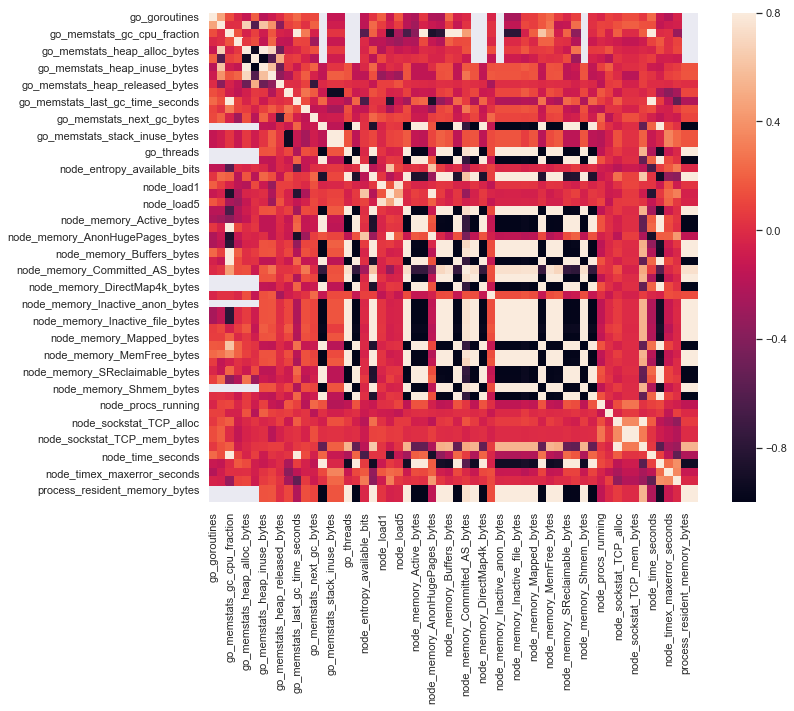

In [143]:
metrics_all_filtered_df = metrics_all_df[non_nan_columns_names]

corrmat = metrics_all_filtered_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);